In [47]:
import sys
sys.path.insert(1, '/users/facsupport/asharma/RNN-shifts/preprocessing')

from data_prep import initial_preprocess

### Generate dataset

RAW_DATA_PATH = '/export/storage_adgandhi/PBJ_data_prep/pbj_full.csv'
PREPROCESSED_DIR = '/users/facsupport/asharma/Data/test'

df, info = initial_preprocess(
    RAW_DATA_PATH, PREPROCESSED_DIR,
    nrows=100000,  
    fill_missing_shifts=True,
    normalize=True,
    day_of_week=True,
    prev_shifts=30,
    fac_data=True
)
df
print(df.columns)

Loading preprocessed data from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_norm_prev_shifts_30_dow_fac.csv'...
Loading related info from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_norm_prev_shifts_30_dow_fac.info.csv'...
Index(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9',
       't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18',
       't_19', 't_20', 't_21', 't_22', 't_23', 't_24', 't_25', 't_26', 't_27',
       't_28', 't_29', 't_30', 'hours', 'employee_id', 'date', 'job_title',
       'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit',
       'avg_dailycensus', 'sd_dailycensus'],
      dtype='object')


In [48]:
import pandas as pd
import lightgbm as lgb

# Keep "interesting" jobs (TODO - use strings instead)
df = df[df['job_title'].isin([33,34,35,11,12,3,5,16,17])]
df['date'] = pd.to_datetime(df['date']).astype(int)
# Convert necessary values to boolean
df.multifac = df.multifac.map(dict(Yes=1, No=0))
df.profit = df.profit.map(dict(Yes=1, No=0))
#Drop employee id and date columns
df = df.drop(columns=['employee_id','date'])

# %%
# ========================================
#          SPLIT & PREP DATAFRAME
# ========================================

inputs = df.drop(['t_0', 'hours'], axis=1)
labels = df.filter(['t_0'])

# Weights to split data set
TRAINING_WEIGHT = 0.7
VALIDATION_WEIGHT = 0.2
TEST_WEIGHT = 0.1

n = len(df)
weights_sum = TRAINING_WEIGHT + VALIDATION_WEIGHT + TEST_WEIGHT
split1 = int(TRAINING_WEIGHT / weights_sum * n)
split2 = int((TRAINING_WEIGHT + VALIDATION_WEIGHT) / weights_sum * n)

train_inputs, train_labels = inputs[:split1], labels[:split1]
val_inputs, val_labels = inputs[split1:split2], labels[split1:split2]
test_inputs, test_labels = inputs[split2:], labels[split2:]

print(train_inputs)
print(train_labels)


            t_1       t_2       t_3       t_4       t_5       t_6       t_7  \
0      0.637781 -1.065263 -1.065263  0.808085  0.751317  0.694549  0.637781   
1      0.694549  0.637781 -1.065263 -1.065263  0.808085  0.751317  0.694549   
2      0.751317  0.694549  0.637781 -1.065263 -1.065263  0.808085  0.751317   
3      0.751317  0.751317  0.694549  0.637781 -1.065263 -1.065263  0.808085   
4     -1.065263  0.751317  0.751317  0.694549  0.637781 -1.065263 -1.065263   
...         ...       ...       ...       ...       ...       ...       ...   
46722  0.581013  0.637781  0.694549  0.808085  0.864853 -1.065263 -1.065263   
46723 -1.065263  0.581013  0.637781  0.694549  0.808085  0.864853 -1.065263   
46724 -1.065263 -1.065263  0.581013  0.637781  0.694549  0.808085  0.864853   
46725 -1.065263 -1.065263  0.694549  0.694549  0.637781  0.637781 -1.065263   
46726  0.637781 -1.065263 -1.065263  0.694549  0.694549  0.637781  0.637781   

            t_8       t_9      t_10  ...      t_30 

In [49]:
# %%
# ========================================
#          DATAFRAME TO LGB DS
# ========================================

cats = ['job_title', 'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit']

train_data = lgb.Dataset(train_inputs, label=train_labels, categorical_feature=cats)
val_data = lgb.Dataset(val_inputs, label=val_labels, categorical_feature=cats)
test_data = lgb.Dataset(test_inputs, label=test_labels, categorical_feature=cats)
print(train_data)

In [50]:
# %%
# ========================================
#            TRAIN WITH LGB
# ========================================
param = {
   'num_leaves': 200,
   'learning_rate': 0.05,
   'metric': 'mse',
   'boosting': 'gbdt',
}
evals_result = {}
bst = lgb.train(param, train_data, valid_sets=[val_data], evals_result=evals_result, early_stopping_rounds=5)

/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7735
[LightGBM] [Info] Number of data points in the train set: 46727, number of used features: 39
[LightGBM] [Info] Start training from score 0.016573


/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's l2: 0.935388
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.898046
[3]	valid_0's l2: 0.864615
[4]	valid_0's l2: 0.833876
[5]	valid_0's l2: 0.805575
[6]	valid_0's l2: 0.780146
[7]	valid_0's l2: 0.75729
[8]	valid_0's l2: 0.736266
[9]	valid_0's l2: 0.717006
[10]	valid_0's l2: 0.699454
[11]	valid_0's l2: 0.683535
[12]	valid_0's l2: 0.668389
[13]	valid_0's l2: 0.655319
[14]	valid_0's l2: 0.643038
[15]	valid_0's l2: 0.632007
[16]	valid_0's l2: 0.621932
[17]	valid_0's l2: 0.612297
[18]	valid_0's l2: 0.603279
[19]	valid_0's l2: 0.595419
[20]	valid_0's l2: 0.587982
[21]	valid_0's l2: 0.581022
[22]	valid_0's l2: 0.57513
[23]	valid_0's l2: 0.569535
[24]	valid_0's l2: 0.564334
[25]	valid_0's l2: 0.559082
[26]	valid_0's l2: 0.555217
[27]	valid_0's l2: 0.551021
[28]	valid_0's l2: 0.547105
[29]	valid_0's l2: 0.543749
[30]	valid_0's l2: 0.540108
[31]	valid_0's l2: 0.536429
[32]	valid_0's l2: 0.533412
[33]	valid_0's l2: 0.530373
[34]	valid_0's l2: 0.527826

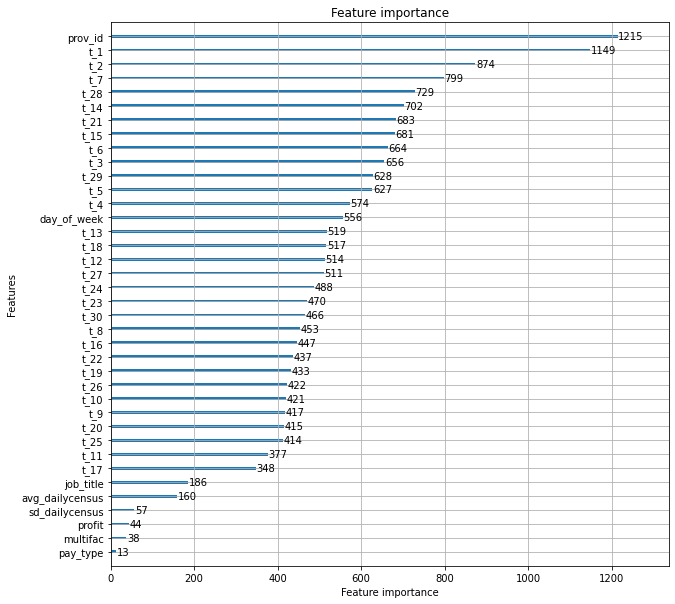

In [51]:
# %%
# =========================================
#          LGB Influence Scores
# =========================================

axes = lgb.plot_importance(bst,figsize=(10,10))

In [52]:
pd.unique(df['prov_id'])

array([ 5, 13, 12,  8,  3,  9, 15, 11,  7,  6, 10,  1, 14,  4,  2])

In [53]:
pd.unique(df['avg_dailycensus'])

array([ 56.15,  96.99, 133.11,  86.62,  37.  ,  94.99,  90.4 ,  59.32,
        68.62, 103.55,  86.47,  34.1 ,  42.39,  55.72,  55.91])

In [59]:
predictions = bst.predict(test_inputs)
MAE=0
RMSE = 0

for i in range(len(test_labels)):
    mean = info['means.hours']
    std = info['stds.hours']
    prediction = predictions[i]*std + mean
    value = test_labels.iloc[i]['t_0']*std + mean
    print(f"Prediction: {prediction} True Value: {value}")
    MAE += abs(prediction-value)
    RMSE += (prediction-value)**2
    
print(f"Mean absolute error {MAE/len(test_labels)}")
print(f"Root mean squared error {(RMSE/len(test_labels))**0.5}")

Prediction: 2.2417369751199274 True Value: 0.0
Prediction: 6.015554784404847 True Value: 0.0
Prediction: 7.148337482687296 True Value: 7.93
Prediction: 7.522951399350118 True Value: 7.73
Prediction: 3.1819774141903814 True Value: 8.67
Prediction: 5.444918075588683 True Value: 0.0
Prediction: 2.474032129088043 True Value: 7.68
Prediction: 7.518208219751502 True Value: 7.720000000000001
Prediction: 8.06990192128509 True Value: 7.82
Prediction: 5.216920823968373 True Value: 0.0
Prediction: 6.047199789284664 True Value: 0.0
Prediction: 5.126486541673382 True Value: 0.0
Prediction: 3.0523039687398414 True Value: 0.0
Prediction: 1.1069842621180679 True Value: 0.0
Prediction: 1.351156995507817 True Value: 0.0
Prediction: 3.000443003639898 True Value: 0.0
Prediction: 3.03279496573678 True Value: 7.77
Prediction: 7.277916845363141 True Value: 8.38
Prediction: 7.050639385616421 True Value: 0.17000000000000082
Prediction: 5.41106300983358 True Value: 0.0
Prediction: 4.718403374671587 True Value: 

Prediction: 3.541807751659486 True Value: 11.42
Prediction: 9.222399356340947 True Value: 7.280000000000001
Prediction: 8.736028063119532 True Value: 11.55
Prediction: 10.814423320541671 True Value: 11.6
Prediction: 3.984701904592851 True Value: 0.0
Prediction: 5.9409620055279495 True Value: 0.0
Prediction: 8.939166921289683 True Value: 0.0
Prediction: 5.34237695656907 True Value: 11.73
Prediction: 3.9704024362946013 True Value: 11.5
Prediction: 2.671147609257897 True Value: 0.0
Prediction: 0.08638830981959345 True Value: 11.67
Prediction: 9.335588896661417 True Value: 0.0
Prediction: 4.4767245470356 True Value: 11.4
Prediction: 4.702234534437664 True Value: 11.43
Prediction: 5.632989311906147 True Value: 11.38
Prediction: 6.4524144977920095 True Value: 0.0
Prediction: 4.390573722798699 True Value: 0.0
Prediction: 5.274309445520787 True Value: 11.48
Prediction: 3.5242438380784646 True Value: 11.45
Prediction: 8.09955357862488 True Value: 0.0
Prediction: 4.890801053765605 True Value: 0.

Prediction: 8.249102535984298 True Value: 6.5
Prediction: 6.41637862079514 True Value: 0.0
Prediction: 5.081609244213039 True Value: 15.0
Prediction: 9.73532333588209 True Value: 13.25
Prediction: 9.4432264102199 True Value: 14.499999999999996
Prediction: 6.860712227064879 True Value: 0.0
Prediction: 4.593401062804876 True Value: 0.0
Prediction: 3.8002134476638187 True Value: 0.0
Prediction: 8.935999097810232 True Value: 13.500000000000002
Prediction: 10.440357670055702 True Value: 7.5
Prediction: 9.478460985083439 True Value: 0.0
Prediction: 2.974896636137184 True Value: 15.0
Prediction: 7.938684661749534 True Value: 15.0
Prediction: 9.470980494616551 True Value: 14.499999999999996
Prediction: 8.890249905157084 True Value: 7.5
Prediction: 4.495272065174319 True Value: 0.0
Prediction: 8.530765128752144 True Value: 14.0
Prediction: 9.2390884832244 True Value: 14.499999999999996
Prediction: 11.201975592499053 True Value: 15.0
Prediction: 4.978613835766134 True Value: 14.25
Prediction: 5.

Prediction: 8.029196365099223 True Value: 8.0
Prediction: 8.250042566232262 True Value: 8.25
Prediction: 7.566456100676802 True Value: 1.5
Prediction: 6.599674328143306 True Value: 8.0
Prediction: 7.110736606997334 True Value: 8.0
Prediction: 3.411082051483489 True Value: 6.5
Prediction: 0.11316589906103047 True Value: 0.0
Prediction: 2.0682791601087387 True Value: 1.5
Prediction: 0.3861409288195219 True Value: 1.5
Prediction: 3.5448681116224954 True Value: 8.0
Prediction: 5.780339326603605 True Value: 6.5
Prediction: 4.093780331286582 True Value: 1.5
Prediction: 7.539173056848005 True Value: 8.0
Prediction: 7.829693077617431 True Value: 8.0
Prediction: 7.540705282015374 True Value: 8.0
Prediction: 4.823459134773021 True Value: 6.5
Prediction: 0.2078092214170022 True Value: 0.0
Prediction: 5.229860572784621 True Value: 1.5
Prediction: 7.749091614777502 True Value: 8.0
Prediction: 7.824209149535717 True Value: 8.0
Prediction: 7.7580665240754545 True Value: 8.0
Prediction: 7.237517086555

In [60]:
print(f"Mean absolute error {errorSum/len(test_labels)}")
print(f"Root mean squared error {(RMSE/len(test_labels))**0.5}")

Mean absolute error 2.504776084818067
Root mean squared error 3.3569404081117002


In [58]:
info

{'nrows': 100000,
 'fill_missing_shifts': True,
 'normalize': True,
 'prev_shifts': 30,
 'day_of_week': True,
 'creation_date': '08/05/2021 15:24:27',
 'means.hours': 4.691289900840598,
 'stds.hours': 4.403879497682054}